## Model training
in this part we will train a machine learning model on the cleaned BBC data set. This implies that we will first train four models and then test our models on a cleaned test set.

In [42]:
import pandas as pd
import numpy as np

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
import bz2
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [7]:
#importing the train set
train = './BBC_data/cleaned_Train.csv'
train_data = pd.read_csv(train)

In [8]:
train_data.head(5)

,Unnamed: 0,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated
0,0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...
1,1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...
2,2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,bbc poll indicates economic gloom citizens in ...,200,bbc poll indicates economic gloom citizens maj...
3,3,1976,lifestyle governs mobile choice faster bett...,tech,3618,lifestyle governs mobile choice faster bett...,200,lifestyle governs mobile choice faster better ...
4,4,917,enron bosses in $168m payout eighteen former e...,business,2190,enron bosses in $168m payout eighteen former e...,200,enron bosses 168m payout eighteen former enron...


### Label encoding 
As a preliminary step, we have to perform label encoding. This will transform our textual labels into numbers between 0 and number of classes - 1.

In [9]:
label_encoder = preprocessing.LabelEncoder()
train_data['category_target'] = label_encoder.fit_transform(train_data['Category'])

In [10]:
train_data.head(2)

,Unnamed: 0,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated,category_target
0,0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...,0
1,1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...,0


### Split the dataset into train and test sets 
In order to have a test set on which we can test our model, we need to sacrifice part of our data and assign it to a test set

In [11]:
#Here we form the features and targets for both train and test set. 
#We are assigning 80% of the data to the train set, and 20% to the test set
X_train, X_test, y_train, y_test = train_test_split(train_data['clean_truncated'], 
                                                    train_data['category_target'], 
                                                    test_size=0.2, 
                                                    random_state=8)

Now we need to perform text vectorization. That is, transform the text into a ector of numbers. We need to do this because we will then have to train our model on numerical features rather than text. 

Concretely we apply the method TfidfVectorizer which transforms each quote into a vector of numbers which represent for each word, the frequency of appearance in the sentence and in the whole dataset.

In [12]:
#Now we need to convert the text in vectorial form 
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 200

In [13]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test


(1192, 200)


### Building the Models
Here we will train four models only with the train dataset. We will then directly assess the model by computing the accuracy on the test dataset

#### Random Forest
The first model we will train is random forest. For theoretical background, see notebook of milestone 2. 

In [87]:
#declare and fit the model
model  = RandomForestClassifier(random_state=1)
model.fit(features_train, labels_train)

#make predictions on the testset
model_predictions = model.predict(features_test)

#print accuracy and other indicative values
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8120805369127517
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        76
           1       0.92      0.77      0.84        47
           2       0.86      0.80      0.83        55
           3       0.81      0.88      0.84        65
           4       0.67      0.78      0.72        55

    accuracy                           0.81       298
   macro avg       0.82      0.81      0.81       298
weighted avg       0.82      0.81      0.81       298



In [88]:
#These are the default parameters of random forest
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

As we see, random forest gives an accuracy of 0.81. Now we can try to increase the accuracy by tuning some of the hyperparameters.

We will tune four hyperparameters: the number of trees to build in each model, the maximal depth, the minimum number of samples needed for a split, and the minimum number of samples in a leaf. To do this we will define several possible values for each of these parameters and then build one model for each possible combination of the values.

In [100]:
#Define a four hyperparameters to tune
n_estimators = [50, 100, 150, 200]
max_depth = [25, 30, 35]
min_samples_split = [3, 4, 5, 6, 7]
min_samples_leaf = [1, 2, 3, 4] 

#define a dict with the different hyperparameters
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(features_train, labels_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


In [101]:
#These are the best values according to the 3-fold cross validation
bestF.best_params_

{'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

In [102]:
#Train the model again but with tuned hyperparameters. 
model1  = RandomForestClassifier(random_state=1,max_depth= 35, min_samples_leaf= 1, min_samples_split= 4, n_estimators= 200)
model1.fit(features_train, labels_train)

#Test the model on the test set
model_predictions = model1.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8154362416107382
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        76
           1       0.97      0.79      0.87        47
           2       0.88      0.78      0.83        55
           3       0.72      0.92      0.81        65
           4       0.74      0.73      0.73        55

    accuracy                           0.82       298
   macro avg       0.83      0.81      0.82       298
weighted avg       0.83      0.82      0.82       298



We see that the accuracy is slightly better than before. It is now of 0.82

#### Logistic Regression
Now we will train a model with logistic regression. Again we will assess the accuracy by applying the model to the test set.

In [174]:
#Define and fit the model using the train sataset
model = LogisticRegression()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8087248322147651
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        76
           1       0.86      0.81      0.84        47
           2       0.84      0.78      0.81        55
           3       0.85      0.82      0.83        65
           4       0.71      0.75      0.73        55

    accuracy                           0.81       298
   macro avg       0.81      0.80      0.81       298
weighted avg       0.81      0.81      0.81       298



We see that the accuracy of this model is 0.81. We can again tune one hyperparameter, the inverse of the regularization strength

In [177]:
#Here we define the values to try for the hypermarameter
param_grid = {'C': [0.1,0.001,1]}

#perform grid search with 3-fold cross validation
clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

bestF = clf.fit(features_train, labels_train)
bestF.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


{'C': 1}

Here we see that the optimal C is 1, which is the default value. Therefore our model does not change

#### KNN
Here we will try a KNN model. Again we will test the model on the test set. 

In [181]:
#Define and fit the model using the train sataset
model = KNeighborsClassifier()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.674496644295302
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        76
           1       0.68      0.72      0.70        47
           2       0.80      0.65      0.72        55
           3       0.56      0.74      0.64        65
           4       0.66      0.53      0.59        55

    accuracy                           0.67       298
   macro avg       0.69      0.67      0.67       298
weighted avg       0.69      0.67      0.67       298



In [116]:
#These are the parameters of the default KNN model
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

The accuracy of the KNN model is of 0.67. For this model we can again tune two parameters, the number of nearest neighbors and the Power parameter for the Minkowski metric.

In [124]:
#Here we define the values to try for the hyperparameters
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 3, 4, 5]}

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, params_KNN, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(features_train, labels_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


In [125]:
#Print the resulting values for the hyperparameters
bestF.best_params_

{'n_neighbors': 1, 'p': 5}

In [182]:
#Perform again fitting and testing of the model with tuned hyperparameters
model = KNeighborsClassifier(n_neighbors=5,p=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.5201342281879194
              precision    recall  f1-score   support

           0       0.52      0.42      0.46        76
           1       0.56      0.60      0.58        47
           2       0.82      0.51      0.63        55
           3       0.42      0.71      0.53        65
           4       0.49      0.38      0.43        55

    accuracy                           0.52       298
   macro avg       0.56      0.52      0.53       298
weighted avg       0.55      0.52      0.52       298



With the tuned hyperparameters we get an accuracy of 0.52, which is worse.

#### Naive Bayes classifier
Here we build and test a naive bayes classifier model. We will not tune any parameters for this model.

In [184]:
#Define and fit the model
model = GaussianNB()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.7281879194630873
              precision    recall  f1-score   support

           0       0.84      0.62      0.71        76
           1       0.93      0.53      0.68        47
           2       0.87      0.75      0.80        55
           3       0.75      0.91      0.82        65
           4       0.51      0.82      0.63        55

    accuracy                           0.73       298
   macro avg       0.78      0.72      0.73       298
weighted avg       0.78      0.73      0.73       298



### Doc2Vec
Since our performances are not particularly high, we will try a different representation of our news articles. Fow this we will use Doc2Vec. Basically it is a different way to give numerical values to the truncated articles. Each article will be represented as a vector.

In [14]:
#We define a new dataset with just the truncated news articles and the corresponding category.
bbc = pd.DataFrame()
bbc['Text'] = train_data['clean_truncated']
bbc['Category'] = train_data['category_target']
bbc.head()

,Text,Category
0,worldcom exboss launches defence lawyers defen...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens maj...,0
3,lifestyle governs mobile choice faster better ...,4
4,enron bosses 168m payout eighteen former enron...,0


In [15]:
#This is a method to assign each document with a tag. This is important for the subsequent steps where we will use Gensim's 
#Doc2Vec implementation. 
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    
    return labeled


#Here we split again in test and train set
X_train, X_test, y_train, y_test = train_test_split(bbc.Text, bbc.Category, random_state=0, test_size=0.3)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [39]:
#Here we train the Doc2Vec model using 30 epochs
def generateDoc2Vec(all_data):
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
    model_dbow.build_vocab([x for x in all_data])

    for epoch in range(30):
        model_dbow.train(utils.shuffle([x for x in all_data]), total_examples=len(all_data), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    return model_dbow
model_dbow = generateDoc2Vec(all_data)

In [17]:
#In this method, we convert the articles into vectors
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.dv[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

Now we will tran again the same models: Random forest, logistic regression, KNN and Naive Bayes. 

#### Random Forest

In [193]:
#Define and fit the model
model = RandomForestClassifier()
model = model.fit(train_vectors_dbow, y_train)

#Test the model
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.901565995525727
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       103
           1       0.90      0.92      0.91        89
           2       0.88      0.91      0.90        81
           3       0.90      0.97      0.93        97
           4       0.90      0.83      0.86        77

    accuracy                           0.90       447
   macro avg       0.90      0.90      0.90       447
weighted avg       0.90      0.90      0.90       447



We get an accuracy of 0.9 with the default parameters of random forest. We will again try to tune the hyperparameters, exactly like above.

In [150]:
#Here we define the values to try for the hyperparameters
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(train_vectors_dbow, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [151]:
#These are the chosen parameters by the cross validation
bestF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [152]:
#Again we fit and test the model but with the chosen values for the hyperparameters
model = RandomForestClassifier(max_depth=30,min_samples_leaf=1,min_samples_split=2,n_estimators=1200)
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.9082774049217002
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       103
           1       0.93      0.91      0.92        89
           2       0.85      0.94      0.89        81
           3       0.91      0.98      0.95        97
           4       0.93      0.83      0.88        77

    accuracy                           0.91       447
   macro avg       0.91      0.91      0.91       447
weighted avg       0.91      0.91      0.91       447



The accuracy slightly improves to 0.91.

#### Logistic Regression

In [211]:
#Define and fit the model
model = LogisticRegression(max_iter=10000)
model = model.fit(train_vectors_dbow, y_train)

#Test the model
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.9194630872483222
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       103
           1       0.93      0.92      0.93        89
           2       0.86      0.94      0.90        81
           3       0.93      0.97      0.95        97
           4       0.93      0.86      0.89        77

    accuracy                           0.92       447
   macro avg       0.92      0.92      0.92       447
weighted avg       0.92      0.92      0.92       447



We get an accuracy of 0.92. Again we can try to tune the hyperparameter C.

In [212]:
#Here we define the values to try for the hyperparameters
param_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10]}

#perform grid search with 3-fold cross validation
clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

bestF = clf.fit(features_train, labels_train)
bestF.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'C': 1}

The optimal value for C is 1, which is already the default value. Therefore our model and accuracy do not change

#### KNN

In [213]:
#Define and fit the model
model = KNeighborsClassifier()
model = model.fit(train_vectors_dbow, y_train)

#Test the model
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.9194630872483222
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       103
           1       0.89      0.92      0.91        89
           2       0.88      0.93      0.90        81
           3       0.99      0.98      0.98        97
           4       0.89      0.84      0.87        77

    accuracy                           0.92       447
   macro avg       0.92      0.92      0.92       447
weighted avg       0.92      0.92      0.92       447



We get an accuracy of 0.92. Again we can perform some hyperparameter tuning.

In [206]:
#Here we define the values to try for the hyperparameters
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 3]}

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, params_KNN, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(train_vectors_dbow, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


In [207]:
#These are the chosen parameters by the cross validation
bestF.best_params_

{'n_neighbors': 7, 'p': 2}

In [208]:
#Again we fit and test the model but with the chosen values for the hyperparameters
model = KNeighborsClassifier(n_neighbors=7,p=2)
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.9172259507829977
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       103
           1       0.92      0.92      0.92        89
           2       0.88      0.94      0.91        81
           3       0.96      0.99      0.97        97
           4       0.89      0.86      0.87        77

    accuracy                           0.92       447
   macro avg       0.92      0.92      0.92       447
weighted avg       0.92      0.92      0.92       447



We end up with an accuracy of 0.92 but slightly lower than with the default parameters. 

#### Naive Bayes classifier

In [173]:
#Define and fit the model
model = GaussianNB()
model.fit(train_vectors_dbow, y_train)

#Test the model
model_predictions = model.predict(test_vectors_dbow)
print('Accuracy: ', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy:  0.8926174496644296
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       103
           1       0.88      0.94      0.91        89
           2       0.85      0.90      0.87        81
           3       0.95      0.96      0.95        97
           4       0.84      0.82      0.83        77

    accuracy                           0.89       447
   macro avg       0.89      0.89      0.89       447
weighted avg       0.89      0.89      0.89       447



We obtain an accuracy of 0.9.

### Conclusion 
We trained and tested several models for both ways of representing sentences as numerical values. 
From the accuracies that we have found, it seems that the best models are KNN and logistic regression, which both have the same accuracy of 0.92.

# Generate label for QuoteBankDataset

We choose the logistic regression model because is able to expresse the probability that a quote is associated at the respective label, and so filtered the quote that don't have high probabilility for the selected class. 

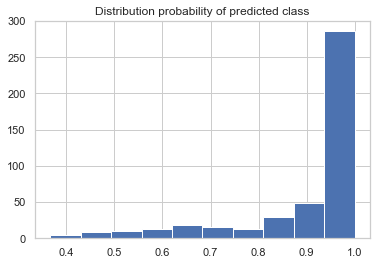

In [30]:
#Define and fit the model
model = LogisticRegression(max_iter=10000)
model = model.fit(train_vectors_dbow, y_train)

#Test the model
model_prediction = model.predict_proba(test_vectors_dbow)
plt.hist(model_prediction.max(axis=1))
plt.title("Distribution probability of predicted class")
plt.show()

So a resonable threshold for the the predicted class is 0.8.

In [92]:
'''
Helper function that add label to a chunck dataframe and save only the row
that we can label with a certain degree of certitude (prob > treshold).
'''
def generate_label(chunk):  
        #generate vector for prediction
        X_ = label_sentences(chunk['quotation'].values, 'Train')
        model_dbow_ = generateDoc2Vec(X_)
        vectors = get_vectors(model_dbow_, len(X_), 300, 'Train')
        
        #predict probability 
        model_prediction = model.predict_proba(vectors)
        
        #select only label with probability greater then 0.8
        mask =model_prediction.max(axis=1) > 0.8
        final_chunk = chunk[mask].copy()
        final_chunk['label'] = model_prediction[mask].argmax(axis=1)
        nb_nonclass = chunk.shape[0] - final_chunk.shape[0]
        
        return final_chunk.reset_index(drop=True), nb_nonclass



In [94]:
'''
Helper function to add label to the dataset of a certain year, 
and filter row that we can't classify. 
'''
def add_label(path_dataset, path_dataset_clean):
    TOT_size = 0
    TOT_size_clean = 0
    TOT_nb_nonclass = 0
    with pd.read_json(path_dataset, lines=True, compression='bz2', chunksize=10000) as df_reader:
        with bz2.open(path_dataset_clean, 'wb') as d_file:
            count = 0
            for chunk in df_reader:
                print(f'({count}) Processing chunk with {chunk.shape[0]} rows', end='\r')
                TOT_size += chunk.shape[0]
                df, nb_nonclass = generate_label(chunk.copy()) 
                
                #count number value
                TOT_nb_nonclass += nb_nonclass
                TOT_size_clean += df.shape[0]

                #Store data for visualisation 
                '''
                counter_quote += Counter(df['quotation'].apply(len))
                counter_date += Counter(df['date'])
                counter_urls += Counter(df['urls'])
                '''
                
                #write in the ouput file
                d_file.write(df.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))
                count+=1
    print(f'We remove {TOT_nb_nonclass} over a total of {TOT_size} ')
    print(f'The final shape of the dataset is {TOT_size_clean}')

Classify qoute of 2020:

In [ ]:
path_dataset = 'quotes-2020-clean.json.bz2' 
path_dataset_clean = 'quotes-2020-clean_classified.json.bz2'
add_label(path_dataset, path_dataset_clean)

Load quote: 

In [97]:
df = pd.read_json(path_dataset_clean, lines=True, compression='bz2')

In [123]:
df.head()

,quotation,speaker,date,qids,urls,label
0,facetoface duty lawyer service provided legal ...,Mike Dwyer,2020-03-18,Q6379626,balonnebeacon.com.au,0
1,act senior secondary students confident meet r...,Yvette Berry,2020-04-01,Q8062355,canberratimes.com.au,0
2,jerry age 24 rotherham due compensation decide...,Jerry Yates,2020-01-10,Q23463606,gazetteandherald.co.uk,0
3,think weve come time prepared women supported ...,Sheila Oliver,2020-01-24,Q7493177,wobm.com,0
4,made clear election manifesto work fans clubs ...,Nigel Adams,2020-02-12,Q258292,nwemail.co.uk,0


In [107]:
print("Count values for the following class:", dict(zip(np.arange(5),label_encoder.inverse_transform(np.arange(5)))))
df.label.value_counts()

Count values for the following class: {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


0    170278
3     13101
2      8353
4      5002
1      4865
Name: label, dtype: int64

In [120]:
print(df[df.label == 3].quotation.values[200])

given level obsession sonics fans regard makers sonic hedgehog would done well turn film slapstick theme park videogame trickery like relentlessly imaginative ralph breaks internet truly epic bad decision far worse original fussy humanoid design sonic make sonic movie one clunky liveaction adventure comedies digitally animated generic weisenheimer plopped middle


In [121]:
#load speaker_attributes
path = "speaker_attributes_final.json.bz2"
speaker_atr = pd.read_json(path, lines=True, compression='bz2')

In [122]:
speaker_atr.head()

,date_of_birth,nationality,gender,id
0,1732,Great Britain,male,Q23
1,1952,United Kingdom,male,Q42
2,1868,Belgium,male,Q1868
3,1946,United States of America,male,Q207
4,1599,Spain,male,Q297


Value Count: 
gender  gender_code
male    1              98
female  0              20
dtype: int64


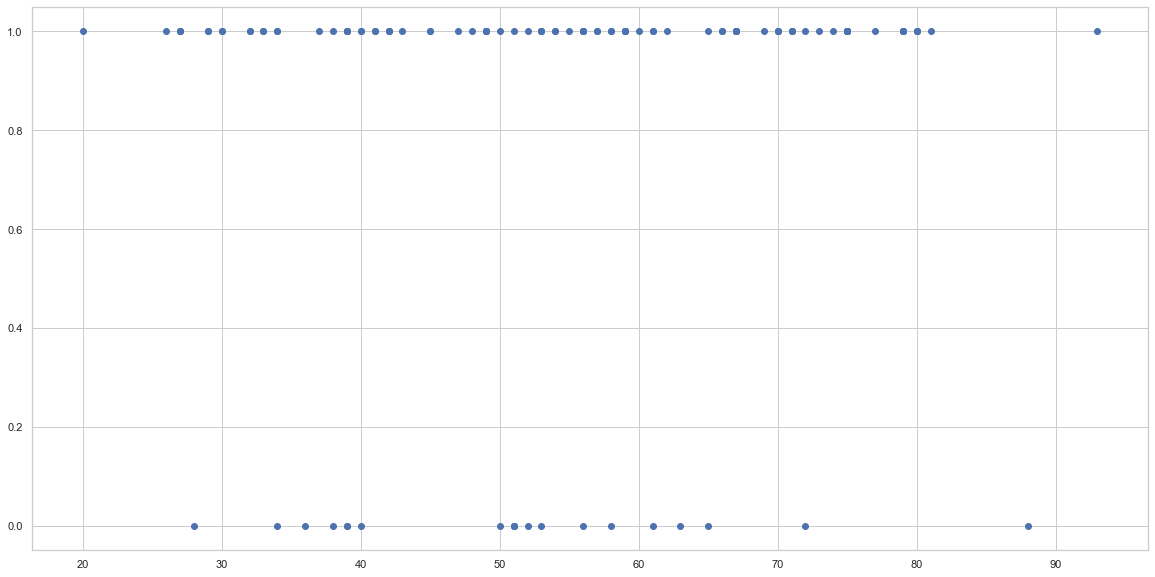

In [146]:
def describe_age_and_gender(site, label, df):
    data = df[df.urls == site] 
    data = data[data.label == 3]
    data = pd.merge(data, speaker_atr,how='inner' ,left_on=['qids'],right_on=['id'])
    data.gender = pd.Categorical(data.gender)
    data['gender_code'] = data.gender.cat.codes
    print("Value Count: ")
    print(data[['gender','gender_code' ]].value_counts())
    plt.figure(figsize=(20, 10))
    plt.plot(2021 - data['date_of_birth'], data['gender_code'], 'o')
    plt.show()
    
describe_age_and_gender('msn.com', 3, df)